# Семинар по бинарной линейной классификации

## Теоретическая часть

### Предсказания в бинарной линейной классификации
__Вспомнить из лекции:__
* Как выполняются предсказания в бинарной линейной классификации?
* Как интерпретировать веса?
* Вспомните обозначения $\langle \cdot, \cdot \rangle$, $sign(z)$, $[z>a]$.

#### Задача 1.
Какое предсказание вернет бинарный линейный классификатор $a(x) = sign(\langle w, x \rangle+w_0)$ для объекта $x=(1, 0, 0, 1, 1)$ при использовании весов $w=(0.1, -0.2, 0.5, -1.1, 0)$ и $w_0=0.35$?

__Решение.__
Запишем скалярное произведение: $\langle w, x \rangle = w_1 x_1 + \dots + w_d x_d$, где $d$ - размерность обоих векторов (число признаков). В нашей задаче $d=5$. Итак, в скобках получится значение $0.1\cdot1 - 0.2\cdot0 + 0.5\cdot 0 -1.1 \cdot 1 + 0 \cdot 1 + 0.3 = -0.7$. Его знак отрицательный, значит $a(x) = -1$.

#### Задача 2.
Визуализируйте разделящую поверхность классификатора $a(x) = sign(\langle w, x \rangle+w_0)$ для $w=(-1, 2)$, $w_0=0.5$, задача бинарной классификации с двумя признаками.

__Решение.__

Предсказания в линейной классификации выполняются по формуле $a(x) = sign(\langle w, x\rangle +w_0)$, то есть класс +1, если выражение в скобках больше 0, и -1, если выражение в скобках меньше 0. Если выражение в скобках равно 0, считаем, что отказываемся от классификации или выбираем случайный класс (на практике такая ситуация встречается очень редко). Соответственно, мы можем сделать такое предсказание в каждой точке признакового пространства, то есть для любого возможного объекта, и получить области классов +1 и -1. Разделяющей границей этих двух областей будет прямая, поэтому классификация линейная.

Разберемся, почему разделяющей границей будет прямая. Вспомним, что уравнение $w_1 x_1 + w_2 x_2 + w_0 = 0$ задает прямую на плоскости в координатах $x_1-x_2$ (мы обычно обозначаем эти координаты $d_1-d_2$, чтобы не путать $x_1$ - первый признак или первый объект в выборке; в данном контексте - первый признак). Все точки $x=(x_1, x_2)$, для которых $w_1 x_1 + w_2 x_2 + w_0 > 0$, находятся с одной стороны от прямой, а все точки, для которых $w_1 x_1 + w_2 x_2 + w_0 < 0$, с другой стороны от прямой. А эти два условия как раз и проверяются в бинарном линейной классификаторе.

В нашем случае прямая задается уравнением $-x_1 + 2 x_2 + 0.5 = 0$. Построим ее по точкам: при $x_1=0$ выполнено $2 x_2+0.5=0$, то есть $x_2=-1/4$; при $x_1=1$ выполнено $2 x_2 -0.5=0$, то есть $x_2=1/4$. Проводим прямую через точки $(0, -1/4)$ и $(1, 1/4)$. Теперь выбираем любую точку, не принадлежащую прямой, например $(0, 1/4)$. Проверяем, какой будет знак выражения $-x_1 + 2 x_2 + 0.5$: $0 + 0.5 + 0.5 = 1 > 0$. Значит, в полуплоскости, где находится эта точка, мы предсказываем класс +1, а в другой - класс -1.

### Вспомнить из лекции
* Какие метрики бинарной классификации вы знаете?
* Какие проблемы есть у метрики accuracy? в каких случаях она нам не подходит?
* Что такое матрица ошибок?

## Практическая часть
В практической части мы обучим линейный классификатор на данных кредитного скорринга, проанализируем веса модели, научимся работать с категориальными признаками в линейных моделях. Далее поработаем с метриками, сравних их между собой и найдем оптимиальные гиперпараметры в модели.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Мы будем работать с [данными клиентов банка](https://archive.ics.uci.edu/ml/datasets/statlog+(german+credit+data) (задача кредитного скоринга). Для целей семинара данные были преобразованы в немного другой формат.

Значение признаков:
* account: банковский счет (-1: отриц. баланс, 0: нет счета, 1: до 200 ед., 2: более 200 ед.)
* duration: на какой период запрашивают кредит
* credit_history: рейтинг по кредитной истории (от 0 - отличная кр. история до 4 - критическая ситуация с кредитами)
* amount: на какую сумму запрашивают кредит
* savings: сберегательный счет (0: нет, 1: < 100, 2: 100 <= ... < 500, 3: 500 <= ... < 1000, 4:  >= 1000)
* employment: срок работы на текущей позиции (0: не работает, 1: до 1 года, 2: от 1 до 4 лет, 3: от 4 до 7 лет, 4: более 7 лет)
* guarantors: 1 - есть поручители, 0 - нет
* residence:  сколько лет резидент
* age: возраст, деленный на 100
* credits_number: число кредитов
* job: 0: не работает, 1: неквалифицированный, 2: квалифицированный специалист, 3: высокая должность или бизнес
* maintenance_people: число людей, которых обеспечивает заемщик
* telephone: указан ли телефон (1: да, 0: нет)
* foreign: 1: иностранец, 0: нет
* real_estate: 1: есть недвижимость, 0: нет недвижимости
* life_insurance: 1: оформлено страхование жизни, 0, нет страховки
* car: 1: есть автомобиль, 0: нет автомобиля
* housing_rent: 1: платит за съем жилья, 0: не платит за съем жилья
* sex: пол - 1: муж., 0: жен.
* purpose: на какую цель запрашивают кредит (из нескольких вариантов)
* target: 1: кредит выдан, 0: в кредите отказано

Требуется решить задачу предсказания значения в последнем столбце, то есть задачу бинарной классификации.

По описанию данных понятно, что все признаки числовые (включая вещественные, порядковые, бинарные), кроме предпоследнего, который является категориальным.

In [3]:
#!pip install xlrd

     |████████████████████████████████| 96 kB 1.7 MB/s eta 0:00:011
You should consider upgrading via the '/Users/filatovartm/Library/Caches/pypoetry/virtualenvs/dpeter-16pq_eh8-py3.7/bin/python -m pip install --upgrade pip' command.


In [2]:
tab = pd.read_excel("https://github.com/nadiinchi/voronovo_seminar_materials/blob/master/base_track/seminars/scoring.xls?raw=true")

In [3]:
type(tab)

pandas.core.frame.DataFrame

In [4]:
tab.head() # вывести первые строки

,account,duration,credit_history,amount,savings,employment,guarantors,residence,age,credits_number,...,maintenance_people,telephone,foreign,real_estate,life_insurance,car,housing_rent,sex,purpose,target
0,1,0.18,2,0.13110,2,2,1,4,0.34,1,...,1,0,1,0,0,1,0,1,business,1
1,-1,0.18,0,0.15520,1,3,1,1,0.31,1,...,1,1,1,0,1,0,0,1,business,1
2,-1,0.12,2,0.04510,1,3,1,4,0.21,1,...,1,0,1,0,1,0,1,1,retraining,0
3,-1,0.30,0,0.40360,0,1,1,3,0.25,3,...,1,0,1,0,0,1,0,1,business,1
4,0,0.36,2,0.09095,1,2,1,4,0.37,1,...,1,1,1,0,0,0,0,1,education,0


По строкам - объекты (клиенты), по столбцам - признаки, последний столбец - целевая переменная (1 - кредит выдан, 0 - в кредите отказано).

In [5]:
tab.dtypes # типы столбцов

account                 int64
duration              float64
credit_history          int64
amount                float64
savings                 int64
employment              int64
guarantors              int64
residence               int64
age                   float64
credits_number          int64
job                     int64
maintenance_people      int64
telephone               int64
foreign                 int64
real_estate             int64
life_insurance          int64
car                     int64
housing_rent            int64
sex                     int64
purpose                object
target                  int64
dtype: object

Признаки в основном числовые.

In [7]:
tab["target"].value_counts()

1    300
0    300
Name: target, dtype: int64

Классы сбалансированы.

Создаем матрицу объекты-признаки и матрицу ответов. Удалим пока столбец с категориальной переменной, чтобы оставить только числовые признаки.

In [8]:
X = tab[tab.columns[:-2]]
y = tab["target"]

In [9]:
X.head()

,account,duration,credit_history,amount,savings,employment,guarantors,residence,age,credits_number,job,maintenance_people,telephone,foreign,real_estate,life_insurance,car,housing_rent,sex
0,1,0.18,2,0.13110,2,2,1,4,0.34,1,2,1,0,1,0,0,1,0,1
1,-1,0.18,0,0.15520,1,3,1,1,0.31,1,2,1,1,1,0,1,0,0,1
2,-1,0.12,2,0.04510,1,3,1,4,0.21,1,2,1,0,1,0,1,0,1,1
3,-1,0.30,0,0.40360,0,1,1,3,0.25,3,2,1,0,1,0,0,1,0,1
4,0,0.36,2,0.09095,1,2,1,4,0.37,1,2,1,1,1,0,0,0,0,1


In [10]:
X.shape, y.shape # атрибут shape показывает размерности матрицы

((600, 19), (600,))

#### Разделение выборки

In [58]:
from sklearn.model_selection import train_test_split
# функция для разделения выборки на обучающую и тестовую

In [59]:
X_train, X_test, y_train, y_test  = train_test_split(X, y, \
                                                     test_size=0.3,\
                                                     shuffle=True,
                                                     random_state=0)

In [60]:
y_train.value_counts()

1    222
0    198
Name: target, dtype: int64

In [61]:
y_test.value_counts()

0    102
1     78
Name: target, dtype: int64

In [62]:
X_train.shape, y_train.shape

((420, 19), (420,))

#### Нормируем данные

In [63]:
from sklearn.preprocessing import StandardScaler

In [64]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#### Импортируем класс модели

In [65]:
from sklearn.linear_model import LinearRegression

In [66]:
from sklearn.metrics import accuracy_score # функция оценки качества

In [67]:
clf_lr = LinearRegression()
clf_lr.fit(X_train, y_train)

LinearRegression()

In [68]:
y_pred = clf_lr.predict(X_test)

In [69]:
accuracy_score(y_test, y_pred > 0.5)

0.6388888888888888

---

#### Важности и веса признаков
Большинство алгоритмов умеют так или иначе оценивать важности признаков. 
В линейной модели в качестве важностей можно рассматривать веса признаков. Они хранятся в атрибуте coef\_ и появляются, конечно, только после вызова процедуры обучения.

In [23]:
clf_lr.coef_

array([ 0.03344627, -0.0779239 ,  0.08754819, -0.02066605,  0.03067396,
        0.06774134, -0.00975411,  0.00109616,  0.0185817 , -0.04661195,
        0.00099741, -0.00569433,  0.01735849, -0.03505761,  0.06359324,
       -0.0134745 ,  0.06344944, -0.0416773 ,  0.05088774])

__Задание.__ Оформить веса признаков в виде датафрейма: первый столбец - имя признака, второй столбец - вес, и отсортировать датафрейм по увеличению веса.

__Решение:__

In [26]:
weights = pd.DataFrame({'feature': X.columns, 'weight': clf_lr.coef_})
weights.sort_values('weight')

,feature,weight
1,duration,-0.077924
9,credits_number,-0.046612
17,housing_rent,-0.041677
13,foreign,-0.035058
3,amount,-0.020666
15,life_insurance,-0.013474
6,guarantors,-0.009754
11,maintenance_people,-0.005694
10,job,0.000997
7,residence,0.001096


Признаки отсортировались по логичным критериям: плата за съем жилья, число кредитов, заемщик-иностранец уменьшают шанс получить кредит; наличие собственности, машины, работы, счета в банке - увеличивают шансы.

Впрочем, некоторые признаки отсортировались менее логично: например, наличие поручителя тоже голосует в "минус", хотя и с маленьким весом.

__Обратите внимание:__ интерпретировать величину весов можно, только если данные отнормированы. Иначе модуль веса будет зависеть от масштаба признака.

#### Работа с категориальным признаком

Применим метод one-hot-encoding к переменной "цель получения кредита", чобы включить ее в модель. Для этого воспользуемся функцией pd.get_dummies

In [27]:
tab_ohe = pd.get_dummies(tab, "purpose")

In [28]:
tab_ohe.head()

,account,duration,credit_history,amount,savings,employment,guarantors,residence,age,credits_number,...,purpose_business,purpose_car_new,purpose_car_used,purpose_domestic_appliances,purpose_education,purpose_furniture,purpose_others,purpose_repairs,purpose_retraining,purpose_television
0,1,0.18,2,0.13110,2,2,1,4,0.34,1,...,1,0,0,0,0,0,0,0,0,0
1,-1,0.18,0,0.15520,1,3,1,1,0.31,1,...,1,0,0,0,0,0,0,0,0,0
2,-1,0.12,2,0.04510,1,3,1,4,0.21,1,...,0,0,0,0,0,0,0,0,1,0
3,-1,0.30,0,0.40360,0,1,1,3,0.25,3,...,1,0,0,0,0,0,0,0,0,0
4,0,0.36,2,0.09095,1,2,1,4,0.37,1,...,0,0,0,0,1,0,0,0,0,0


In [29]:
# удаляем целевую переменную с помощью метода drop
X_ohe = tab_ohe.drop("target", axis=1)
# axis=1 показывает, что мы отим удалить столбец, а не строку (axis=0)

In [30]:
X_train_ohe, X_test_ohe, y_train, y_test  = train_test_split(X_ohe, y, \
                                                     test_size=0.3,\
                                                     shuffle=True,
                                                     random_state=0)

In [31]:
scaler = StandardScaler()
X_train_ohe = scaler.fit_transform(X_train_ohe)
X_test_ohe = scaler.transform(X_test_ohe)

Благодаря фиксации random_state=0 мы получаем одно и то же разделение.

Оформим обучение классификатора и подсчет качества в виде функции:

In [32]:
def get_accuracy(clf):
    clf.fit(X_train_ohe, y_train)
    y_pred = clf.predict(X_test_ohe)
    return accuracy_score(y_test, y_pred > 0.5)

In [33]:
print(get_accuracy(LinearRegression()))

0.6666666666666666


Качество с новым признаком повысилось.

А что, если мы просто пронумеруем категории? Для этого воспользуемся классом LabelEncoder:

In [34]:
from sklearn.preprocessing import LabelEncoder

In [35]:
le = LabelEncoder()
tab["purpose"] = le.fit_transform(tab["purpose"])

In [36]:
X_le = tab[tab.columns[:-1]]

In [37]:
X_train_le, X_test_le, y_train, y_test  = train_test_split(X_le, y, \
                                                     test_size=0.3,\
                                                     shuffle=True,
                                                     random_state=0)

In [38]:
scaler = StandardScaler()
X_train_le = scaler.fit_transform(X_train_le)
X_test_le = scaler.transform(X_test_le)

In [39]:
def get_accuracy(clf):
    clf.fit(X_train_le, y_train)
    y_pred = clf.predict(X_test_le)
    return accuracy_score(y_test, y_pred > 0.5)

In [40]:
print(get_accuracy(LinearRegression()))

0.65


---

Посчитаем метрики нашей модели. Метрики разобранные на лекции уже реализованы в библиотеке scikit-learn.

In [ ]:
##        alg
##      +1 -1
## +1   TP FN
## -1   FP TN

$$
PR = \dfrac{TP}{TP + FP}
$$

(relevant objects among retrieved, доля ответов класса 1 среди тех, которые алгоритм назвал принадлежащими к классу 1)

$$
R = \dfrac{TP}{TP + FN} = TPR = sensitivity
$$

(retrieved objects among relevant, доля верно предсказанных ответов класса 1)

$$
F_{\beta} = \dfrac{(1 + \beta^2) PR \times R}{\beta^2 \times PR + R}
$$

$$
F_1 = \dfrac{2 PR \times R}{PR + R}
$$

In [70]:
from sklearn.metrics import precision_score, recall_score, confusion_matrix, f1_score

In [71]:
confusion_matrix(y_test, y_pred > 0.5)

array([[53, 49],
       [16, 62]])

In [72]:
precision_score(y_test, y_pred > 0.5)

0.5585585585585585

In [73]:
recall_score(y_test, y_pred > 0.5)

0.7948717948717948

In [74]:
f1_score(y_test, y_pred > 0.5)

0.656084656084656

Порог 0.5 мы выбрали самостоятельно, и мы можем его менять. Как увелечиение порога отразится на precision/recall?

На практике, перед нами всегда встает трейдофф - потерять часть сигнала взамен на большую точность или получить false positives взамен на больший recall.

**Пояснение:**
1) Чем больше порог, тем меньше объектов относим к классу 1 (относим только объекты с большими вероятностями), а значит снижаем вероятность того, что алгоритм отнесёт к классу 1 объект класса 0 (алгоритм становится более точным в обнаружении объектов класса 1) = снижаем FP. Таким образом, precision повышается. 

2) Аналогично, так как мы относим к классу 1 меньше объектов, recall понижается по определению.

Постройте на одном графике precision, recall и f1 score в зависимости от порога.

In [75]:
thresholds = np.arange(0, 1, 0.1)
pr = []
rec = []
f1 = []

for t in thresholds:
    pr.append(precision_score(y_test, y_pred > t))
    rec.append(recall_score(y_test, y_pred > t))
    f1.append(f1_score(y_test, y_pred > t))

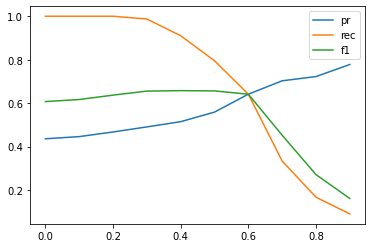

In [77]:
plt.plot(thresholds, pr, label = 'pr')
plt.plot(thresholds, rec, label = 'rec')
plt.plot(thresholds, f1, label = 'f1')
plt.legend()

Какой порог соответствует максимизации f1 score?

**Ответ:** примерно 0.4

Обучите линейную регрессию с регуляризацией и подберите параметр регуляризации исходя из максимального f1-score.

In [ ]:
# 1) X -> X_train, X_val, X_test
# 2) X -> X_train, X_test, cross_val(X_train)

In [80]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold

alphas = np.arange(0.1, 20, 1)
scores = []

for alph in alphas:
    kf = KFold(5)
    lr = Ridge(alpha = alph)
    cv_scores = []
    
    for tr_ind, ts_ind in kf.split(X_train):
        X_tr, X_ts = X_train[tr_ind, :], X_train[ts_ind, :]
        y_tr, y_ts = y_train.iloc[tr_ind], y_train.iloc[ts_ind]
        lr.fit(X_tr, y_tr)
        cv_scores.append(f1_score(y_ts, lr.predict(X_ts) > 0.4))
        
    scores.append(np.mean(cv_scores))

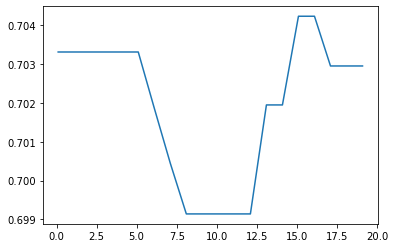

In [82]:
plt.plot(alphas, scores)